# Train LSTM network using Keypoint Features

## Import libraries

In [1]:
# Basic functions
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils
import vidutils

## Create Training and Test Sets

### Load training data
Choose between using synthetic data, real data or both. 

Usage example: If only real data is to be used, set `real_data` to `True` and `syn_data` to `False`.

In [2]:
### --------------------------------------------
# Choose datasets to use
real_data = True
syn_data = False
### --------------------------------------------

X_paths = [] # paths of segment folders
y = [] # designated label

if real_data:
    # Specify directories
    frame_folder = "./data/frames"
    
    # Construct X = folder names, y = the label
    vf_list = []
    for f in os.listdir(frame_folder):
        if not f.startswith('.'):
            vf_list.append(f)
    
    for vf_folder in vf_list:
        # Create path to video
        vf_path = os.path.join(frame_folder, vf_folder)
        print("Current Video: "+ vf_folder)

        # Get individual segment folder
        segfolder_list = os.listdir(vf_path)

        # Check every segment folder
        for seg_folder in segfolder_list:

            if not seg_folder.startswith('.'):
                x_path = os.path.join(vf_path, seg_folder)
                X_paths.append(x_path + '/features.npz')

                # Extract class label from folder name
                label = int(seg_folder.split("_")[2])
                y.append(label)
        
if syn_data:
    # define synthetic data directory
    output_dir = './synthetic_data/output'
    output_list = os.listdir(output_dir)

    for output_folder in output_list:
        if output_folder.startswith('vid'):
            x_path = output_dir + '/' + output_folder
            X_paths.append(x_path)

            # Extract class label from folder name
            params = re.findall(r'\d+', output_folder)
            label = int( (int(params[3]) - 1) / 100)
            y.append(label)

Current Video: video1
Current Video: video2
Current Video: video3
Current Video: video4


In [3]:
# Preview Data distribution
from collections import Counter
Counter(y)

Counter({1: 54, 2: 49, 4: 50, 5: 51, 8: 52, 9: 52, 0: 48, 3: 50, 6: 48, 7: 50})

In [4]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))
#print(test_X_paths)

Training Set: (453,453)
Test Set: (51,51)


### Conversion to Pytorch Dataset
Set seeds for reproducibility and produce pytorch tensor for training.

In [5]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

Definition of dataset class and normalization function

In [6]:
# Define Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        num_frames = 20
        
        # extract features (different based on synthetic or real)
        if npz_path.startswith('./data/'):
            X_feat = data['feature_array']
        else:
            X_feat = vidutils.reshape_syn_features \
            (data['subset_all'][:num_frames], data['candidate_all'][:num_frames])
        
         # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor

# Define normalization function
class norm_with_saved(object):
    """
    Rescale each feature by subtracting mean and dividing by SD over all subjects
    IMPORTANT: Calculate saved_mean and saved_std first.
    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

In [7]:
# precalculate means and std
dataset = []
training_dataset = SyncDataset(X = train_X_paths, y = train_ys)
for train_X, train_y in training_dataset:
    new_row = train_X.data.numpy()
    if len(dataset) == 0:
        dataset = new_row
    else:
        dataset = np.vstack((dataset,new_row))
saved_mean = np.mean(dataset, axis=0) 
saved_std = np.std(dataset, axis=0) 
saved_std[saved_std == 0] = 0.00001 # prevent error dividing by 0

# Define Transformer
transformer = transforms.Compose([
    norm_with_saved(),
    transforms.ToTensor()
])

In [8]:
# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)
print(len(training_dataset))

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)
print(len(testing_dataset))

453
51


In [9]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y

(torch.Size([20, 168]), 6)

### Define Data Loader  

Data Loader for extracting batches from the Pytorch Dataset during model training

In [10]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [11]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

In [12]:
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


## Model Definition 
Define LSTM architecture and optimizer settings.

In [13]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168
        
        # Define Model Structure
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        output = self.fc1(output)
        return output

Choose between regression or classification model and select type of loss.

Modify `loss_fn` and `weight_path` to choose the most appropriate loss function and save the results in a directory of your choice.

In [14]:
### --------------------------------------------
# Choose whether to use classification model or regression model
classif_model = True
reg_model = False
### --------------------------------------------
assert (classif_model != reg_model), print("ERROR: Choose one model only")

# Define Loss Function
if classif_model:
    loss_fn = nn.CrossEntropyLoss(reduction="sum")
    weight_path = "./models/weights_norm_kpf_classifier.pt"
    num_class = 10

if reg_model:
    # choose between L1 and MSE
    #loss_fn = nn.L1Loss(reduction="sum")
    loss_fn = nn.MSELoss(reduction="sum")
    weight_path = "./models/weights_norm_kpf_regressor.pt"
    num_class = 1


# RNN Model Parameters
model_params = {
    "num_classes": num_class,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 200, # Best classifier: 200
}
model = SyncRNN(model_params)

In [15]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.zeros(1, 50, 168)
    y = model(x)
    print(y.shape) # should be [1,1,10] for classification and [1,1,1] for regression

torch.Size([1, 1, 10])


In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    cuda_available = True
else:
    device = torch.device("cpu")
    cuda_available = False
    
# Print Model Params
model = model.to(device)
model

SyncRNN(
  (rnn): LSTM(168, 200)
  (fc1): Linear(in_features=200, out_features=10, bias=True)
)

Define optimizer settings

In [17]:
# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 0.2)

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

In [18]:
# Define Training Parameters
train_params = {
    "num_epochs": 200, 
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": weight_path,
    "cuda_available": cuda_available
}

## Model Training  

Train network and display train/test accuracies.

In [19]:
# train model
if classif_model:
    trained_model, loss_hist, metric_hist = trainutils.train_model_class(model, train_params)
if reg_model:
    trained_model, loss_hist, metric_hist = trainutils.train_model_reg(model, train_params)

Epoch 0/199, current_lr=0.2



Saved best model weights
Train Loss: 4.863459, Dev Loss: 6.801388, Accuracy: 7.84
----------
Epoch 1/199, current_lr=0.2



Train Loss: 5.888536, Dev Loss: 6.872366, Accuracy: 7.84
----------
Epoch 2/199, current_lr=0.2



Saved best model weights
Train Loss: 5.941216, Dev Loss: 5.707905, Accuracy: 11.76
----------
Epoch 3/199, current_lr=0.2



Train Loss: 5.378596, Dev Loss: 6.039924, Accuracy: 9.80
----------
Epoch 4/199, current_lr=0.2



Train Loss: 5.248209, Dev Loss: 5.770314, Accuracy: 3.92
----------
Epoch 5/199, current_lr=0.2



Train Loss: 5.303875, Dev Loss: 7.395170, Accuracy: 7.84
----------
Epoch 6/199, current_lr=0.2



Train Loss: 5.426344, Dev Loss: 5.714092, Accuracy: 13.73
----------
Epoch 7/199, current_lr=0.2



Saved best model weights
Train Loss: 5.631199, Dev Loss: 5.121730, Accuracy: 9.80
----------
Epoch 8/199, current_lr=0.2



Train Loss: 5.006470, Dev Loss: 6.150276, Accuracy: 5.88
----------
Epoch 9/199, current_lr=0.2



Train Loss: 5.128211, Dev Loss: 5.939684, Accuracy: 21.57
----------
Epoch 10/199, current_lr=0.2



Train Loss: 4.938119, Dev Loss: 6.334380, Accuracy: 5.88
----------
Epoch 11/199, current_lr=0.2



Train Loss: 5.178124, Dev Loss: 5.313617, Accuracy: 17.65
----------
Epoch 12/199, current_lr=0.2



Train Loss: 5.001231, Dev Loss: 6.996785, Accuracy: 11.76
----------
Epoch 13/199, current_lr=0.2



Epoch    14: reducing learning rate of group 0 to 1.4000e-01.
Loading best model weights
Train Loss: 4.902175, Dev Loss: 7.042602, Accuracy: 7.84
----------
Epoch 14/199, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 4.560038, Dev Loss: 5.038180, Accuracy: 15.69
----------
Epoch 15/199, current_lr=0.13999999999999999



Train Loss: 4.195255, Dev Loss: 5.157220, Accuracy: 15.69
----------
Epoch 16/199, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 4.223150, Dev Loss: 4.729742, Accuracy: 15.69
----------
Epoch 17/199, current_lr=0.13999999999999999



Train Loss: 3.989185, Dev Loss: 5.335142, Accuracy: 7.84
----------
Epoch 18/199, current_lr=0.13999999999999999



Train Loss: 3.800820, Dev Loss: 5.723723, Accuracy: 11.76
----------
Epoch 19/199, current_lr=0.13999999999999999



Train Loss: 3.689400, Dev Loss: 4.879201, Accuracy: 9.80
----------
Epoch 20/199, current_lr=0.13999999999999999



Train Loss: 3.777795, Dev Loss: 4.859651, Accuracy: 13.73
----------
Epoch 21/199, current_lr=0.13999999999999999



Train Loss: 3.581198, Dev Loss: 5.475261, Accuracy: 11.76
----------
Epoch 22/199, current_lr=0.13999999999999999



Epoch    23: reducing learning rate of group 0 to 9.8000e-02.
Loading best model weights
Train Loss: 3.705029, Dev Loss: 5.539252, Accuracy: 11.76
----------
Epoch 23/199, current_lr=0.09799999999999999



Train Loss: 3.497268, Dev Loss: 4.908528, Accuracy: 11.76
----------
Epoch 24/199, current_lr=0.09799999999999999



Train Loss: 3.545705, Dev Loss: 4.865020, Accuracy: 7.84
----------
Epoch 25/199, current_lr=0.09799999999999999



Saved best model weights
Train Loss: 3.439393, Dev Loss: 4.578965, Accuracy: 11.76
----------
Epoch 26/199, current_lr=0.09799999999999999



Saved best model weights
Train Loss: 3.254133, Dev Loss: 3.811470, Accuracy: 13.73
----------
Epoch 27/199, current_lr=0.09799999999999999



Train Loss: 3.267703, Dev Loss: 4.012486, Accuracy: 7.84
----------
Epoch 28/199, current_lr=0.09799999999999999



Train Loss: 2.932731, Dev Loss: 3.964047, Accuracy: 11.76
----------
Epoch 29/199, current_lr=0.09799999999999999



Saved best model weights
Train Loss: 3.004509, Dev Loss: 3.469412, Accuracy: 11.76
----------
Epoch 30/199, current_lr=0.09799999999999999



Train Loss: 2.910932, Dev Loss: 3.809715, Accuracy: 15.69
----------
Epoch 31/199, current_lr=0.09799999999999999



Train Loss: 2.950351, Dev Loss: 4.051779, Accuracy: 5.88
----------
Epoch 32/199, current_lr=0.09799999999999999



Train Loss: 2.703664, Dev Loss: 4.850624, Accuracy: 7.84
----------
Epoch 33/199, current_lr=0.09799999999999999



Train Loss: 3.005595, Dev Loss: 3.778663, Accuracy: 17.65
----------
Epoch 34/199, current_lr=0.09799999999999999



Train Loss: 2.852650, Dev Loss: 4.086261, Accuracy: 17.65
----------
Epoch 35/199, current_lr=0.09799999999999999



Epoch    36: reducing learning rate of group 0 to 6.8600e-02.
Loading best model weights
Train Loss: 2.693430, Dev Loss: 4.046151, Accuracy: 9.80
----------
Epoch 36/199, current_lr=0.0686



Train Loss: 2.734860, Dev Loss: 3.893937, Accuracy: 11.76
----------
Epoch 37/199, current_lr=0.0686



Train Loss: 2.511163, Dev Loss: 3.533441, Accuracy: 5.88
----------
Epoch 38/199, current_lr=0.0686



Saved best model weights
Train Loss: 2.542880, Dev Loss: 3.290008, Accuracy: 17.65
----------
Epoch 39/199, current_lr=0.0686



Train Loss: 2.448682, Dev Loss: 3.445968, Accuracy: 23.53
----------
Epoch 40/199, current_lr=0.0686



Train Loss: 2.458362, Dev Loss: 3.812667, Accuracy: 15.69
----------
Epoch 41/199, current_lr=0.0686



Train Loss: 2.383316, Dev Loss: 3.994600, Accuracy: 7.84
----------
Epoch 42/199, current_lr=0.0686



Train Loss: 2.403525, Dev Loss: 4.029724, Accuracy: 11.76
----------
Epoch 43/199, current_lr=0.0686



Train Loss: 2.478871, Dev Loss: 3.850329, Accuracy: 5.88
----------
Epoch 44/199, current_lr=0.0686



Epoch    45: reducing learning rate of group 0 to 4.8020e-02.
Loading best model weights
Train Loss: 2.434676, Dev Loss: 3.653502, Accuracy: 13.73
----------
Epoch 45/199, current_lr=0.04801999999999999



Train Loss: 2.321728, Dev Loss: 3.920122, Accuracy: 11.76
----------
Epoch 46/199, current_lr=0.04801999999999999



Train Loss: 2.223860, Dev Loss: 3.574321, Accuracy: 13.73
----------
Epoch 47/199, current_lr=0.04801999999999999



Train Loss: 2.218536, Dev Loss: 3.373331, Accuracy: 13.73
----------
Epoch 48/199, current_lr=0.04801999999999999



Train Loss: 2.195413, Dev Loss: 3.428937, Accuracy: 9.80
----------
Epoch 49/199, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 2.078883, Dev Loss: 3.272967, Accuracy: 15.69
----------
Epoch 50/199, current_lr=0.04801999999999999



Train Loss: 2.041118, Dev Loss: 3.274989, Accuracy: 11.76
----------
Epoch 51/199, current_lr=0.04801999999999999



Train Loss: 2.080391, Dev Loss: 3.436061, Accuracy: 9.80
----------
Epoch 52/199, current_lr=0.04801999999999999



Train Loss: 2.072095, Dev Loss: 3.545479, Accuracy: 11.76
----------
Epoch 53/199, current_lr=0.04801999999999999



Train Loss: 2.031345, Dev Loss: 3.427268, Accuracy: 21.57
----------
Epoch 54/199, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 2.022860, Dev Loss: 3.231692, Accuracy: 11.76
----------
Epoch 55/199, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 1.866067, Dev Loss: 3.147910, Accuracy: 11.76
----------
Epoch 56/199, current_lr=0.04801999999999999



Train Loss: 1.929334, Dev Loss: 3.866124, Accuracy: 9.80
----------
Epoch 57/199, current_lr=0.04801999999999999



Train Loss: 1.993504, Dev Loss: 3.413506, Accuracy: 7.84
----------
Epoch 58/199, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 2.002986, Dev Loss: 3.069973, Accuracy: 11.76
----------
Epoch 59/199, current_lr=0.04801999999999999



Train Loss: 1.912605, Dev Loss: 3.330439, Accuracy: 9.80
----------
Epoch 60/199, current_lr=0.04801999999999999



Train Loss: 1.841136, Dev Loss: 3.251101, Accuracy: 13.73
----------
Epoch 61/199, current_lr=0.04801999999999999



Train Loss: 1.978219, Dev Loss: 3.279865, Accuracy: 17.65
----------
Epoch 62/199, current_lr=0.04801999999999999



Train Loss: 1.887056, Dev Loss: 3.179310, Accuracy: 15.69
----------
Epoch 63/199, current_lr=0.04801999999999999



Train Loss: 1.925349, Dev Loss: 3.735793, Accuracy: 13.73
----------
Epoch 64/199, current_lr=0.04801999999999999



Epoch    65: reducing learning rate of group 0 to 3.3614e-02.
Loading best model weights
Train Loss: 1.949771, Dev Loss: 3.655292, Accuracy: 9.80
----------
Epoch 65/199, current_lr=0.03361399999999999



Train Loss: 1.886696, Dev Loss: 3.429183, Accuracy: 7.84
----------
Epoch 66/199, current_lr=0.03361399999999999



Train Loss: 1.815581, Dev Loss: 3.286777, Accuracy: 13.73
----------
Epoch 67/199, current_lr=0.03361399999999999



Train Loss: 1.823169, Dev Loss: 3.574379, Accuracy: 5.88
----------
Epoch 68/199, current_lr=0.03361399999999999



Train Loss: 1.798696, Dev Loss: 3.385716, Accuracy: 9.80
----------
Epoch 69/199, current_lr=0.03361399999999999



Train Loss: 1.727583, Dev Loss: 3.431532, Accuracy: 5.88
----------
Epoch 70/199, current_lr=0.03361399999999999



Epoch    71: reducing learning rate of group 0 to 2.3530e-02.
Loading best model weights
Train Loss: 1.880671, Dev Loss: 3.279785, Accuracy: 11.76
----------
Epoch 71/199, current_lr=0.023529799999999993



Train Loss: 1.892972, Dev Loss: 3.457992, Accuracy: 11.76
----------
Epoch 72/199, current_lr=0.023529799999999993



Train Loss: 1.715908, Dev Loss: 3.212084, Accuracy: 9.80
----------
Epoch 73/199, current_lr=0.023529799999999993



Saved best model weights
Train Loss: 1.776738, Dev Loss: 3.058687, Accuracy: 9.80
----------
Epoch 74/199, current_lr=0.023529799999999993



Train Loss: 1.736488, Dev Loss: 3.230404, Accuracy: 13.73
----------
Epoch 75/199, current_lr=0.023529799999999993



Train Loss: 1.714866, Dev Loss: 3.467810, Accuracy: 9.80
----------
Epoch 76/199, current_lr=0.023529799999999993



Train Loss: 1.711184, Dev Loss: 3.315582, Accuracy: 15.69
----------
Epoch 77/199, current_lr=0.023529799999999993



Train Loss: 1.697279, Dev Loss: 3.737005, Accuracy: 9.80
----------
Epoch 78/199, current_lr=0.023529799999999993



Train Loss: 1.671193, Dev Loss: 3.327589, Accuracy: 17.65
----------
Epoch 79/199, current_lr=0.023529799999999993



Epoch    80: reducing learning rate of group 0 to 1.6471e-02.
Loading best model weights
Train Loss: 1.706979, Dev Loss: 3.411355, Accuracy: 13.73
----------
Epoch 80/199, current_lr=0.016470859999999993



Train Loss: 1.703749, Dev Loss: 3.283310, Accuracy: 15.69
----------
Epoch 81/199, current_lr=0.016470859999999993



Train Loss: 1.699247, Dev Loss: 3.697426, Accuracy: 17.65
----------
Epoch 82/199, current_lr=0.016470859999999993



Train Loss: 1.697111, Dev Loss: 3.571738, Accuracy: 3.92
----------
Epoch 83/199, current_lr=0.016470859999999993



Train Loss: 1.644441, Dev Loss: 3.133985, Accuracy: 13.73
----------
Epoch 84/199, current_lr=0.016470859999999993



Train Loss: 1.597851, Dev Loss: 3.674016, Accuracy: 7.84
----------
Epoch 85/199, current_lr=0.016470859999999993



Epoch    86: reducing learning rate of group 0 to 1.1530e-02.
Loading best model weights
Train Loss: 1.601795, Dev Loss: 3.264724, Accuracy: 3.92
----------
Epoch 86/199, current_lr=0.011529601999999995



Saved best model weights
Train Loss: 1.717641, Dev Loss: 3.034305, Accuracy: 17.65
----------
Epoch 87/199, current_lr=0.011529601999999995



Train Loss: 1.680927, Dev Loss: 3.141341, Accuracy: 13.73
----------
Epoch 88/199, current_lr=0.011529601999999995



Train Loss: 1.581923, Dev Loss: 3.384182, Accuracy: 11.76
----------
Epoch 89/199, current_lr=0.011529601999999995



Train Loss: 1.640810, Dev Loss: 3.159925, Accuracy: 15.69
----------
Epoch 90/199, current_lr=0.011529601999999995



Train Loss: 1.598516, Dev Loss: 3.355493, Accuracy: 13.73
----------
Epoch 91/199, current_lr=0.011529601999999995



Train Loss: 1.632216, Dev Loss: 3.036937, Accuracy: 19.61
----------
Epoch 92/199, current_lr=0.011529601999999995



Epoch    93: reducing learning rate of group 0 to 8.0707e-03.
Loading best model weights
Train Loss: 1.579815, Dev Loss: 3.415905, Accuracy: 7.84
----------
Epoch 93/199, current_lr=0.008070721399999996



Train Loss: 1.655412, Dev Loss: 3.361711, Accuracy: 9.80
----------
Epoch 94/199, current_lr=0.008070721399999996



Train Loss: 1.590675, Dev Loss: 3.519256, Accuracy: 7.84
----------
Epoch 95/199, current_lr=0.008070721399999996



Train Loss: 1.603963, Dev Loss: 3.311640, Accuracy: 9.80
----------
Epoch 96/199, current_lr=0.008070721399999996



Train Loss: 1.640315, Dev Loss: 3.207942, Accuracy: 9.80
----------
Epoch 97/199, current_lr=0.008070721399999996



Train Loss: 1.587215, Dev Loss: 3.359821, Accuracy: 5.88
----------
Epoch 98/199, current_lr=0.008070721399999996



Epoch    99: reducing learning rate of group 0 to 5.6495e-03.
Loading best model weights
Train Loss: 1.659609, Dev Loss: 3.526155, Accuracy: 9.80
----------
Epoch 99/199, current_lr=0.005649504979999997



Saved best model weights
Train Loss: 1.652182, Dev Loss: 2.947443, Accuracy: 15.69
----------
Epoch 100/199, current_lr=0.005649504979999997



Train Loss: 1.580917, Dev Loss: 3.107807, Accuracy: 13.73
----------
Epoch 101/199, current_lr=0.005649504979999997



Train Loss: 1.643970, Dev Loss: 3.026062, Accuracy: 11.76
----------
Epoch 102/199, current_lr=0.005649504979999997



Train Loss: 1.650733, Dev Loss: 3.133051, Accuracy: 5.88
----------
Epoch 103/199, current_lr=0.005649504979999997



Train Loss: 1.649837, Dev Loss: 3.481553, Accuracy: 9.80
----------
Epoch 104/199, current_lr=0.005649504979999997



Train Loss: 1.552607, Dev Loss: 3.204085, Accuracy: 11.76
----------
Epoch 105/199, current_lr=0.005649504979999997



Epoch   106: reducing learning rate of group 0 to 3.9547e-03.
Loading best model weights
Train Loss: 1.538429, Dev Loss: 3.147514, Accuracy: 9.80
----------
Epoch 106/199, current_lr=0.003954653485999997



Train Loss: 1.715959, Dev Loss: 3.365589, Accuracy: 5.88
----------
Epoch 107/199, current_lr=0.003954653485999997



Train Loss: 1.674369, Dev Loss: 2.996256, Accuracy: 11.76
----------
Epoch 108/199, current_lr=0.003954653485999997



Train Loss: 1.607314, Dev Loss: 3.300399, Accuracy: 9.80
----------
Epoch 109/199, current_lr=0.003954653485999997



Train Loss: 1.553873, Dev Loss: 3.169871, Accuracy: 11.76
----------
Epoch 110/199, current_lr=0.003954653485999997



Train Loss: 1.586680, Dev Loss: 3.212419, Accuracy: 15.69
----------
Epoch 111/199, current_lr=0.003954653485999997



Epoch   112: reducing learning rate of group 0 to 2.7683e-03.
Loading best model weights
Train Loss: 1.567886, Dev Loss: 3.643073, Accuracy: 13.73
----------
Epoch 112/199, current_lr=0.0027682574401999976



Train Loss: 1.642508, Dev Loss: 3.073953, Accuracy: 17.65
----------
Epoch 113/199, current_lr=0.0027682574401999976



Train Loss: 1.677977, Dev Loss: 3.269291, Accuracy: 15.69
----------
Epoch 114/199, current_lr=0.0027682574401999976



Train Loss: 1.653525, Dev Loss: 3.095878, Accuracy: 9.80
----------
Epoch 115/199, current_lr=0.0027682574401999976



Train Loss: 1.575782, Dev Loss: 3.201538, Accuracy: 13.73
----------
Epoch 116/199, current_lr=0.0027682574401999976



Train Loss: 1.566696, Dev Loss: 3.155707, Accuracy: 11.76
----------
Epoch 117/199, current_lr=0.0027682574401999976



Epoch   118: reducing learning rate of group 0 to 1.9378e-03.
Loading best model weights
Train Loss: 1.512029, Dev Loss: 3.387545, Accuracy: 19.61
----------
Epoch 118/199, current_lr=0.0019377802081399981



Train Loss: 1.686415, Dev Loss: 3.120278, Accuracy: 13.73
----------
Epoch 119/199, current_lr=0.0019377802081399981



Train Loss: 1.616944, Dev Loss: 3.277672, Accuracy: 17.65
----------
Epoch 120/199, current_lr=0.0019377802081399981



Train Loss: 1.649166, Dev Loss: 3.151939, Accuracy: 13.73
----------
Epoch 121/199, current_lr=0.0019377802081399981



Train Loss: 1.586266, Dev Loss: 3.220154, Accuracy: 9.80
----------
Epoch 122/199, current_lr=0.0019377802081399981



Train Loss: 1.599168, Dev Loss: 3.318539, Accuracy: 9.80
----------
Epoch 123/199, current_lr=0.0019377802081399981



Epoch   124: reducing learning rate of group 0 to 1.3564e-03.
Loading best model weights
Train Loss: 1.585100, Dev Loss: 3.397880, Accuracy: 5.88
----------
Epoch 124/199, current_lr=0.0013564461456979987



Train Loss: 1.619740, Dev Loss: 3.232174, Accuracy: 17.65
----------
Epoch 125/199, current_lr=0.0013564461456979987



Train Loss: 1.615897, Dev Loss: 3.247224, Accuracy: 13.73
----------
Epoch 126/199, current_lr=0.0013564461456979987



Train Loss: 1.679636, Dev Loss: 3.422791, Accuracy: 15.69
----------
Epoch 127/199, current_lr=0.0013564461456979987



Train Loss: 1.556450, Dev Loss: 3.247160, Accuracy: 15.69
----------
Epoch 128/199, current_lr=0.0013564461456979987



Train Loss: 1.643409, Dev Loss: 3.281100, Accuracy: 11.76
----------
Epoch 129/199, current_lr=0.0013564461456979987



Epoch   130: reducing learning rate of group 0 to 9.4951e-04.
Loading best model weights
Train Loss: 1.605758, Dev Loss: 3.337814, Accuracy: 13.73
----------
Epoch 130/199, current_lr=0.000949512301988599



Train Loss: 1.610331, Dev Loss: 3.390175, Accuracy: 5.88
----------
Epoch 131/199, current_lr=0.000949512301988599



Train Loss: 1.590374, Dev Loss: 3.437534, Accuracy: 11.76
----------
Epoch 132/199, current_lr=0.000949512301988599



Train Loss: 1.565950, Dev Loss: 3.130540, Accuracy: 7.84
----------
Epoch 133/199, current_lr=0.000949512301988599



Saved best model weights
Train Loss: 1.602807, Dev Loss: 2.938668, Accuracy: 15.69
----------
Epoch 134/199, current_lr=0.000949512301988599



Train Loss: 1.706033, Dev Loss: 3.346912, Accuracy: 11.76
----------
Epoch 135/199, current_lr=0.000949512301988599



Train Loss: 1.582851, Dev Loss: 3.036752, Accuracy: 19.61
----------
Epoch 136/199, current_lr=0.000949512301988599



Train Loss: 1.632829, Dev Loss: 3.211774, Accuracy: 9.80
----------
Epoch 137/199, current_lr=0.000949512301988599



Train Loss: 1.621948, Dev Loss: 3.511040, Accuracy: 15.69
----------
Epoch 138/199, current_lr=0.000949512301988599



Train Loss: 1.614668, Dev Loss: 3.338041, Accuracy: 13.73
----------
Epoch 139/199, current_lr=0.000949512301988599



Epoch   140: reducing learning rate of group 0 to 6.6466e-04.
Loading best model weights
Train Loss: 1.548866, Dev Loss: 3.375611, Accuracy: 9.80
----------
Epoch 140/199, current_lr=0.0006646586113920192



Train Loss: 1.571870, Dev Loss: 3.213717, Accuracy: 11.76
----------
Epoch 141/199, current_lr=0.0006646586113920192



Train Loss: 1.547966, Dev Loss: 3.334102, Accuracy: 5.88
----------
Epoch 142/199, current_lr=0.0006646586113920192



Train Loss: 1.528818, Dev Loss: 3.410202, Accuracy: 9.80
----------
Epoch 143/199, current_lr=0.0006646586113920192



Train Loss: 1.588952, Dev Loss: 3.477043, Accuracy: 15.69
----------
Epoch 144/199, current_lr=0.0006646586113920192



Train Loss: 1.650546, Dev Loss: 3.021279, Accuracy: 13.73
----------
Epoch 145/199, current_lr=0.0006646586113920192



Epoch   146: reducing learning rate of group 0 to 4.6526e-04.
Loading best model weights
Train Loss: 1.614588, Dev Loss: 3.186568, Accuracy: 5.88
----------
Epoch 146/199, current_lr=0.0004652610279744134



Train Loss: 1.583087, Dev Loss: 2.949309, Accuracy: 7.84
----------
Epoch 147/199, current_lr=0.0004652610279744134



Train Loss: 1.652507, Dev Loss: 3.215699, Accuracy: 9.80
----------
Epoch 148/199, current_lr=0.0004652610279744134



Train Loss: 1.583711, Dev Loss: 3.115039, Accuracy: 15.69
----------
Epoch 149/199, current_lr=0.0004652610279744134



Train Loss: 1.610040, Dev Loss: 3.331482, Accuracy: 9.80
----------
Epoch 150/199, current_lr=0.0004652610279744134



Train Loss: 1.560024, Dev Loss: 3.247445, Accuracy: 15.69
----------
Epoch 151/199, current_lr=0.0004652610279744134



Epoch   152: reducing learning rate of group 0 to 3.2568e-04.
Loading best model weights
Train Loss: 1.652703, Dev Loss: 3.411433, Accuracy: 7.84
----------
Epoch 152/199, current_lr=0.0003256827195820893



Train Loss: 1.594523, Dev Loss: 3.317096, Accuracy: 13.73
----------
Epoch 153/199, current_lr=0.0003256827195820893



Train Loss: 1.652957, Dev Loss: 2.946817, Accuracy: 17.65
----------
Epoch 154/199, current_lr=0.0003256827195820893



Train Loss: 1.606441, Dev Loss: 3.218267, Accuracy: 11.76
----------
Epoch 155/199, current_lr=0.0003256827195820893



Saved best model weights
Train Loss: 1.520279, Dev Loss: 2.871819, Accuracy: 15.69
----------
Epoch 156/199, current_lr=0.0003256827195820893



Train Loss: 1.604874, Dev Loss: 3.450026, Accuracy: 11.76
----------
Epoch 157/199, current_lr=0.0003256827195820893



Train Loss: 1.583558, Dev Loss: 3.094291, Accuracy: 9.80
----------
Epoch 158/199, current_lr=0.0003256827195820893



Train Loss: 1.634870, Dev Loss: 3.084790, Accuracy: 11.76
----------
Epoch 159/199, current_lr=0.0003256827195820893



Train Loss: 1.637137, Dev Loss: 3.028912, Accuracy: 11.76
----------
Epoch 160/199, current_lr=0.0003256827195820893



Train Loss: 1.600928, Dev Loss: 3.225080, Accuracy: 11.76
----------
Epoch 161/199, current_lr=0.0003256827195820893



Epoch   162: reducing learning rate of group 0 to 2.2798e-04.
Loading best model weights
Train Loss: 1.561973, Dev Loss: 3.164211, Accuracy: 11.76
----------
Epoch 162/199, current_lr=0.00022797790370746252



Train Loss: 1.566002, Dev Loss: 2.980135, Accuracy: 15.69
----------
Epoch 163/199, current_lr=0.00022797790370746252



Train Loss: 1.649256, Dev Loss: 3.202684, Accuracy: 7.84
----------
Epoch 164/199, current_lr=0.00022797790370746252



Train Loss: 1.641500, Dev Loss: 3.314309, Accuracy: 7.84
----------
Epoch 165/199, current_lr=0.00022797790370746252



Train Loss: 1.618683, Dev Loss: 3.304243, Accuracy: 7.84
----------
Epoch 166/199, current_lr=0.00022797790370746252



Train Loss: 1.580017, Dev Loss: 3.134426, Accuracy: 11.76
----------
Epoch 167/199, current_lr=0.00022797790370746252



Epoch   168: reducing learning rate of group 0 to 1.5958e-04.
Loading best model weights
Train Loss: 1.568453, Dev Loss: 3.427260, Accuracy: 13.73
----------
Epoch 168/199, current_lr=0.00015958453259522375



Train Loss: 1.586693, Dev Loss: 3.302541, Accuracy: 11.76
----------
Epoch 169/199, current_lr=0.00015958453259522375



Train Loss: 1.677391, Dev Loss: 3.258990, Accuracy: 9.80
----------
Epoch 170/199, current_lr=0.00015958453259522375



Train Loss: 1.602023, Dev Loss: 3.359013, Accuracy: 5.88
----------
Epoch 171/199, current_lr=0.00015958453259522375



Train Loss: 1.578652, Dev Loss: 3.385665, Accuracy: 13.73
----------
Epoch 172/199, current_lr=0.00015958453259522375



Train Loss: 1.649557, Dev Loss: 3.472517, Accuracy: 11.76
----------
Epoch 173/199, current_lr=0.00015958453259522375



Epoch   174: reducing learning rate of group 0 to 1.1171e-04.
Loading best model weights
Train Loss: 1.622575, Dev Loss: 3.138481, Accuracy: 5.88
----------
Epoch 174/199, current_lr=0.00011170917281665661



Train Loss: 1.579956, Dev Loss: 3.120961, Accuracy: 21.57
----------
Epoch 175/199, current_lr=0.00011170917281665661



Train Loss: 1.602837, Dev Loss: 3.174551, Accuracy: 9.80
----------
Epoch 176/199, current_lr=0.00011170917281665661



Train Loss: 1.619062, Dev Loss: 3.128797, Accuracy: 17.65
----------
Epoch 177/199, current_lr=0.00011170917281665661



Train Loss: 1.574281, Dev Loss: 3.527691, Accuracy: 7.84
----------
Epoch 178/199, current_lr=0.00011170917281665661



Train Loss: 1.586502, Dev Loss: 3.541502, Accuracy: 15.69
----------
Epoch 179/199, current_lr=0.00011170917281665661



Epoch   180: reducing learning rate of group 0 to 7.8196e-05.
Loading best model weights
Train Loss: 1.575547, Dev Loss: 3.408344, Accuracy: 7.84
----------
Epoch 180/199, current_lr=7.819642097165963e-05



Train Loss: 1.599676, Dev Loss: 3.036411, Accuracy: 19.61
----------
Epoch 181/199, current_lr=7.819642097165963e-05



Train Loss: 1.748840, Dev Loss: 3.008624, Accuracy: 19.61
----------
Epoch 182/199, current_lr=7.819642097165963e-05



Train Loss: 1.578700, Dev Loss: 3.399241, Accuracy: 1.96
----------
Epoch 183/199, current_lr=7.819642097165963e-05



Saved best model weights
Train Loss: 1.565971, Dev Loss: 2.812619, Accuracy: 15.69
----------
Epoch 184/199, current_lr=7.819642097165963e-05



Train Loss: 1.640046, Dev Loss: 2.988723, Accuracy: 19.61
----------
Epoch 185/199, current_lr=7.819642097165963e-05



Train Loss: 1.692782, Dev Loss: 3.254811, Accuracy: 15.69
----------
Epoch 186/199, current_lr=7.819642097165963e-05



Train Loss: 1.586500, Dev Loss: 3.255916, Accuracy: 17.65
----------
Epoch 187/199, current_lr=7.819642097165963e-05



Train Loss: 1.570734, Dev Loss: 3.073290, Accuracy: 19.61
----------
Epoch 188/199, current_lr=7.819642097165963e-05



Train Loss: 1.640966, Dev Loss: 3.576930, Accuracy: 7.84
----------
Epoch 189/199, current_lr=7.819642097165963e-05



Epoch   190: reducing learning rate of group 0 to 5.4737e-05.
Loading best model weights
Train Loss: 1.601630, Dev Loss: 3.363772, Accuracy: 9.80
----------
Epoch 190/199, current_lr=5.473749468016174e-05



Train Loss: 1.643565, Dev Loss: 3.040773, Accuracy: 19.61
----------
Epoch 191/199, current_lr=5.473749468016174e-05



Train Loss: 1.585732, Dev Loss: 3.307318, Accuracy: 11.76
----------
Epoch 192/199, current_lr=5.473749468016174e-05



Train Loss: 1.545798, Dev Loss: 3.284826, Accuracy: 17.65
----------
Epoch 193/199, current_lr=5.473749468016174e-05



Train Loss: 1.595065, Dev Loss: 3.440330, Accuracy: 5.88
----------
Epoch 194/199, current_lr=5.473749468016174e-05



Train Loss: 1.588754, Dev Loss: 3.239599, Accuracy: 15.69
----------
Epoch 195/199, current_lr=5.473749468016174e-05



Epoch   196: reducing learning rate of group 0 to 3.8316e-05.
Loading best model weights
Train Loss: 1.546505, Dev Loss: 3.384497, Accuracy: 19.61
----------
Epoch 196/199, current_lr=3.8316246276113215e-05



Train Loss: 1.633752, Dev Loss: 3.003015, Accuracy: 21.57
----------
Epoch 197/199, current_lr=3.8316246276113215e-05



Train Loss: 1.591335, Dev Loss: 2.918827, Accuracy: 9.80
----------
Epoch 198/199, current_lr=3.8316246276113215e-05



Train Loss: 1.580924, Dev Loss: 3.308018, Accuracy: 5.88
----------
Epoch 199/199, current_lr=3.8316246276113215e-05



Train Loss: 1.559138, Dev Loss: 3.514722, Accuracy: 13.73
----------


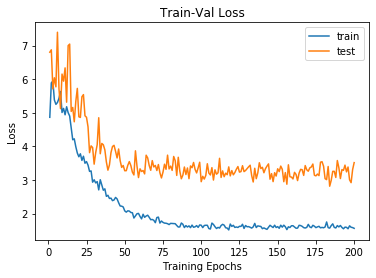

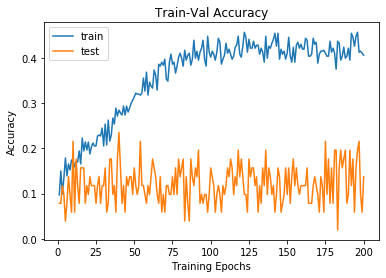

In [20]:
trainutils.plot_loss(loss_hist, metric_hist)